In [16]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [17]:
from SuchTree import SuchTree, SuchLinkedTrees
import graphkernels.kernels as gk
import igraph
import pandas
import seaborn
import json
import pyprind

In [4]:
studies = json.load( open( '../SuchTree/data/studies.json' ) )

In [5]:
def load_study( study ) :
    T1  = SuchTree( '../SuchTree/' + study['host'] )
    T2  = SuchTree( '../SuchTree/' + study['guest'] )
    links = pandas.DataFrame.from_csv( '../SuchTree/' + study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

p = pyprind.ProgBar( len(studies) )

for n, study in enumerate(studies) :

    p.update()
    
    SLT = load_study( study )
    
    study['SLT'] = SLT
    
    host_aj,  host_node_ids  = SLT.TreeA.adjacency( SLT.TreeA.root ).values()
    guest_aj, guest_node_ids = SLT.TreeB.adjacency( SLT.TreeB.root ).values()
    
    g = igraph.Graph.Weighted_Adjacency( SLT.adjacency().tolist(), mode=igraph.ADJ_UNDIRECTED )
    g.vs['label'] = list(host_node_ids) + list(guest_node_ids)
    g.vs['tree'] = [ 0 ]  * len( host_node_ids ) + [ 1 ] * len( guest_node_ids )
    color_dict = { 0 : 'blue', 1 : 'red' }
    g.vs['color'] = [color_dict[tree] for tree in g.vs['tree']]
    layout = g.layout_kamada_kawai()
    #igraph.plot( glg, layout=layout )

    study['igraph'] = g

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:10:23


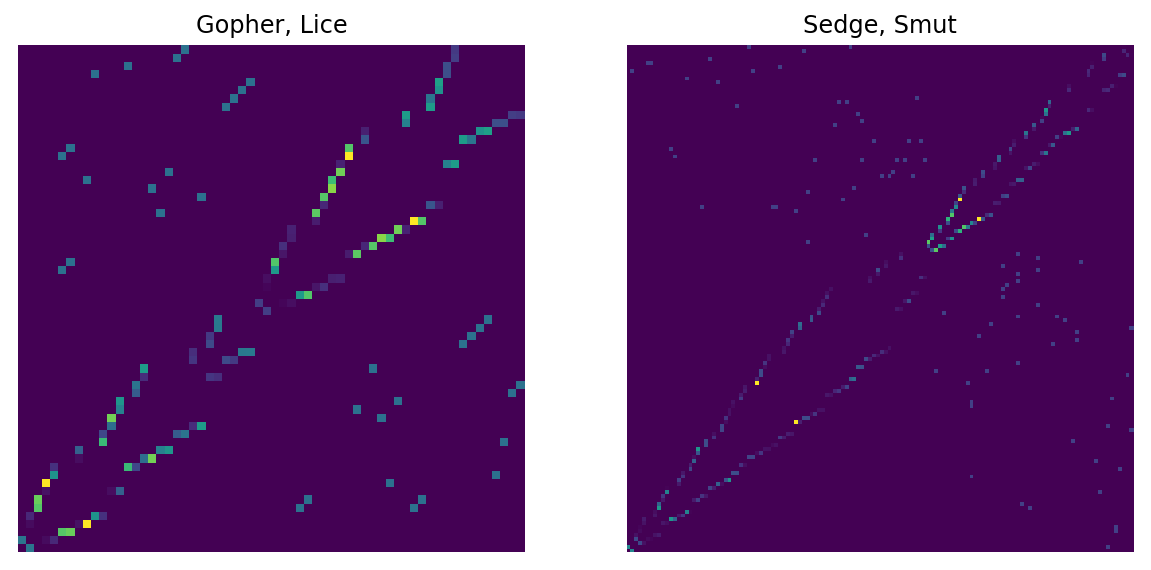

In [18]:
figure( figsize=(10,10) )

subplot(1,2,1)
title( studies[0]['name'] )
seaborn.heatmap( studies[0]['SLT'].adjacency(), cmap='viridis', 
                 vmin=0, vmax=1,
                 xticklabels=False, yticklabels=False,
                 cbar=False, square=True ).invert_yaxis()
subplot(1,2,2)
title( studies[1]['name'] )
seaborn.heatmap( studies[1]['SLT'].adjacency(), cmap='viridis', 
                 vmin=0, vmax=1,
                 xticklabels=False, yticklabels=False,
                 cbar=False, square=True ).invert_yaxis()

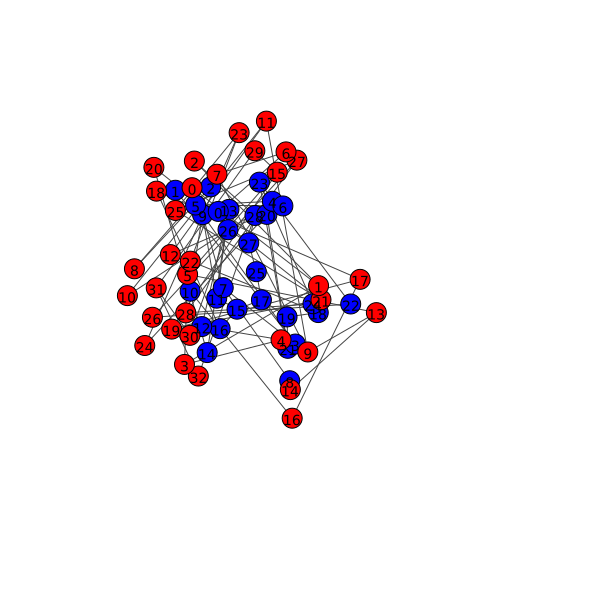

In [7]:
igraph.plot( studies[0]['igraph'], layout=layout )

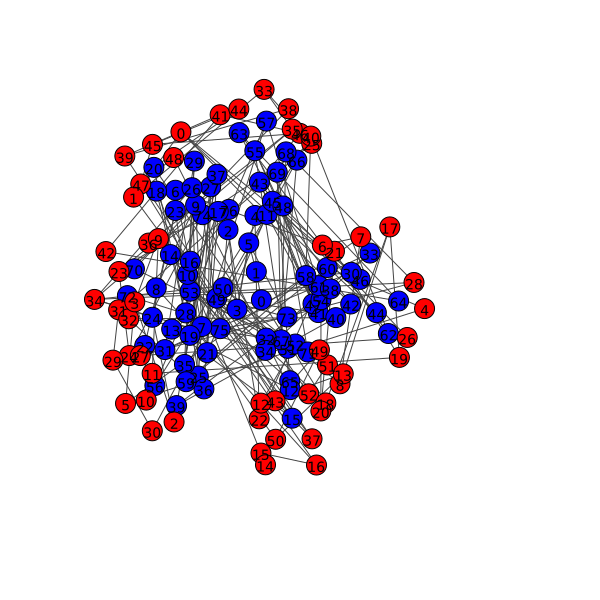

In [8]:
igraph.plot( studies[1]['igraph'], layout=layout )

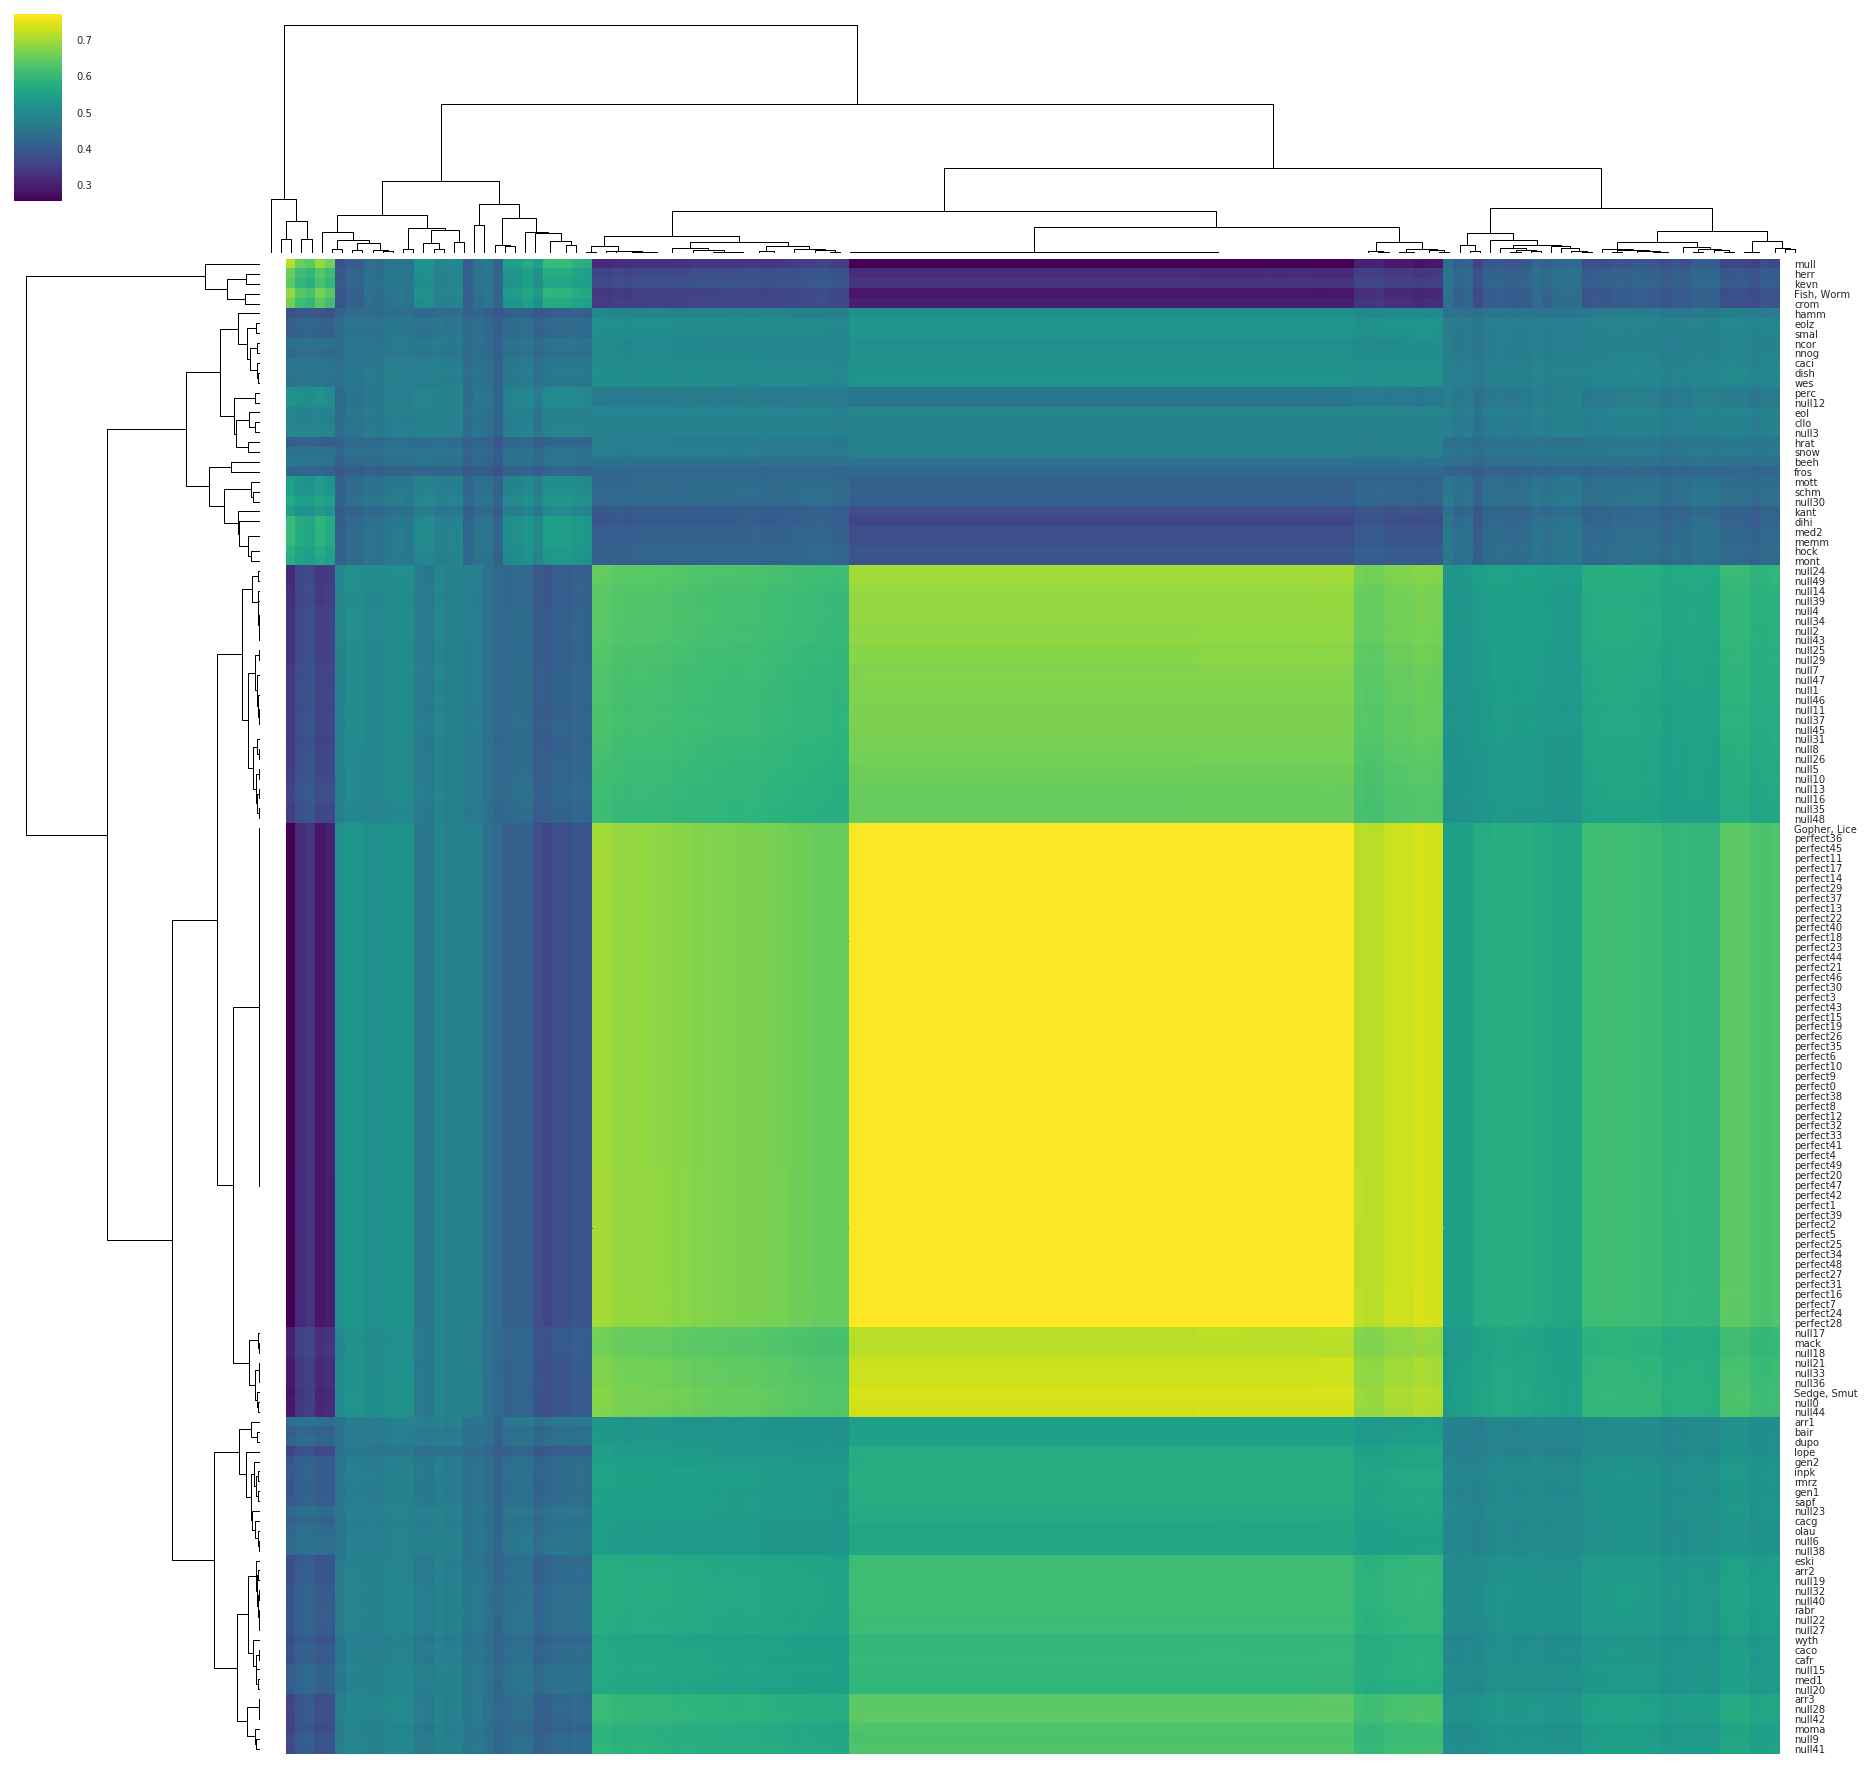

In [27]:
K = gk.CalculateConnectedGraphletKernel( [ i['igraph'] for i in studies ] )

seaborn.set( font_scale=0.5 )
seaborn.clustermap( K, method='weighted', metric='braycurtis',
                    cmap='viridis', figsize=(16,16),
                    xticklabels=False, yticklabels=[ i['name'] for i in studies ],
                    cbar=True, square=True )